In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
lps_clinical_table_age = pd.read_csv(
    "./MLHC/Data/raw_data/Participant_table/Participant_table all metabolmics data available.csv")
lps_clinical_table_sex = pd.read_csv(
    "./MLHC/Data/raw_data/Participant_table/Participant_table all metabolmics data available with gender.csv")
lps_clinical_table_age.drop(columns=["Age when attended assessment centre | Instance 0"], inplace=True)

full_clinical_table = lps_clinical_table_age.merge(lps_clinical_table_sex, on="Participant ID")

# Input icd10 list
icd10_info = pd.read_csv("./MLHC/Data/raw_data/icd10_tree_information.csv")

In [4]:
icd10_info_non_cancer = icd10_info[icd10_info['category'] != "Cancer"].copy()
icd10_info_non_cancer.dropna(subset=['date_key_number'], inplace=True)
icd10_info_non_cancer['date_key_number'] = icd10_info_non_cancer['date_key_number'].astype(int).astype(str)
non_canacer_col_keys = icd10_info_non_cancer['date_key_number'].tolist()
print("Number of non cancer icd10:", icd10_info_non_cancer.shape[0])

icd10_info_cancer = icd10_info[icd10_info['category'] == "Cancer"].copy()
print("Number of cancer icd10:", icd10_info_cancer.shape[0])
cancer_codes = icd10_info_cancer["coding"].to_list()

Number of non cancer icd10: 1130
Number of cancer icd10: 90


In [ ]:
raw_df = pd.read_csv("./MLHC/Data/raw_data/patient_to_all_icd10_dates_lps_individuals.csv")
filtered_df = pd.read_csv("./MLHC/Data/preprocessed_data/LPs_ind/patient_to_all_icd10_dates_lps_individuals_filtered.csv")

In [4]:
icd10_cols = filtered_df[filtered_df["split_group"]=="train"].iloc[:,8:]
# non_infections_icd10_cols = filtered_df[filtered_df["split_group"]=="train"].iloc[:,168:]
num_icd10 = (icd10_cols.notna().sum() > 0).sum()

print("Number of total different ICD10 codes:", num_icd10)

Number of total different ICD10 codes: 1187


In [9]:
def cohort_summary(df, diagnosis_cols, select_code=None):
    """
    Summarize patient cohort demographics and diagnosis timelines.

    Parameters
    ----------
    df : pandas.DataFrame
        Patient-level data. Must include 'Sex', 'dob', 'doa', and diagnosis date columns.
    diagnosis_cols : list of str
        Columns containing diagnosis dates.
    select_code : str, optional
        Column for a specific diagnosis. If provided, the given df is filtered to
        include only individuals who were diagnosed with that code.
    """

    filtered_df = df.copy()
    n_whole_pop = filtered_df.shape[0]

    if select_code is not None:
        filtered_df = df[df[select_code].notna()].copy()

    filtered_df[diagnosis_cols] = filtered_df[diagnosis_cols].apply(pd.to_datetime, errors="coerce")
    filtered_df['doa'] = pd.to_datetime(filtered_df['doa'], errors="coerce")
    filtered_df['dob'] = pd.to_datetime(filtered_df['dob'], errors="coerce")

    n_individuals = filtered_df.shape[0]
    n_females = (filtered_df["Sex"] == "Female").sum()
    n_males = (filtered_df["Sex"] == "Male").sum()

    all_diagnosis_dates = pd.to_datetime(filtered_df[diagnosis_cols].values.ravel(), errors="coerce")
    all_diagnosis_dates = all_diagnosis_dates.dropna()

    diagnosis_counts = filtered_df[diagnosis_cols].notna().sum(axis=1)
    median_num_diagnoses = diagnosis_counts.median()

    first_diag = filtered_df[diagnosis_cols].min(axis=1)
    last_diag = filtered_df[diagnosis_cols].max(axis=1)
    trajectory_years = (last_diag - first_diag).dt.days / 365.25
    median_trajectory_years = trajectory_years.median()

    if select_code is not None:
        age_at_diagnosis = (filtered_df[select_code] - filtered_df["dob"]).dt.days / 365.25
        median_age_at_diagnosis = age_at_diagnosis.median()
        n_subset = filtered_df.shape[0]
        code_prevalence = (n_subset / n_whole_pop) * 100

        pre_0_3, pre_3_6, pre_6_12, pre_gt_12 = 0, 0, 0, 0

        for _, row in filtered_df.iterrows():
            diagnosis_date = row[select_code]
            diag_dates = pd.to_datetime(row[diagnosis_cols].dropna())
            deltas = (diagnosis_date - diag_dates).dt.days

            pre_0_3   += ((deltas >= 0) & (deltas <= 90)).sum()
            pre_3_6   += ((deltas > 90) & (deltas <= 180)).sum()
            pre_6_12  += ((deltas > 180) & (deltas <= 365)).sum()
            pre_gt_12 += (deltas > 365).sum()

    print("Number of individuals:", n_individuals)
    print("Number of female:", n_females, f"({n_females / n_individuals * 100:.2f}%)")
    print("Number of male:", n_males, f"({n_males / n_individuals * 100:.2f}%)")
    print("Number of diagnoses:", len(all_diagnosis_dates))
    print("Diagnoses starting at:", all_diagnosis_dates.min().year)
    print("Diagnoses ending at:", all_diagnosis_dates.max().year)
    print("Median number of diagnoses:", median_num_diagnoses)
    print("Median trajectory years:", median_trajectory_years)



    if select_code is not None:
        print(f"Disease prevalence: {code_prevalence}%")
        print("Median age at diagnosis:", median_age_at_diagnosis)
        print("Number of disease 0-3 months pre diagnosis:", pre_0_3)
        print("Number of disease 3-6 months pre diagnosis:", pre_3_6)
        print("Number of disease 6-12 months pre diagnosis:", pre_6_12)
        print("Number of disease >12 months pre diagnosis:", pre_gt_12)


In [6]:
diagnosis_cols = filtered_df.columns[8:]

In [7]:
# Summary for the entire dataset
cohort_summary(filtered_df, diagnosis_cols, None)

Number of individuals: 209662
Number of female: 114506 (54.61%)
Number of male: 95156 (45.39%)
Number of diagnoses: 3300947
Diagnoses starting at: 1938
Diagnoses ending at: 2023
Median number of diagnoses: 13.0
Median trajectory years: 31.017111567419576


In [10]:
# Summary for the pancreatic cancer diagnosed subset
cohort_summary(filtered_df, diagnosis_cols, 'C25')

/tmp/ipykernel_3287301/1067938266.py:23: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  filtered_df['doa'] = pd.to_datetime(filtered_df['doa'], errors="coerce")


Number of individuals: 827
Number of female: 408 (49.33%)
Number of male: 419 (50.67%)
Number of diagnoses: 15932
Diagnoses starting at: 1940
Diagnoses ending at: 2022
Median number of diagnoses: 17.0
Median trajectory years: 27.759069130732374
Disease prevalence: 0.39444439144909427%
Median age at diagnosis: 69.56605065023956
Number of disease 0-3 months pre diagnosis: 2719
Number of disease 3-6 months pre diagnosis: 274
Number of disease 6-12 months pre diagnosis: 275
Number of disease >12 months pre diagnosis: 8300


In [11]:
# Summary for the breast cancer diagnosed subset
cohort_summary(filtered_df, diagnosis_cols, 'C50')

/tmp/ipykernel_3287301/1067938266.py:23: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  filtered_df['doa'] = pd.to_datetime(filtered_df['doa'], errors="coerce")


Number of individuals: 8807
Number of female: 8752 (99.38%)
Number of male: 55 (0.62%)
Number of diagnoses: 152378
Diagnoses starting at: 1939
Diagnoses ending at: 2023
Median number of diagnoses: 15.0
Median trajectory years: 31.123887748117728
Disease prevalence: 4.200570441949424%
Median age at diagnosis: 59.148528405201915
Number of disease 0-3 months pre diagnosis: 10806
Number of disease 3-6 months pre diagnosis: 994
Number of disease 6-12 months pre diagnosis: 1988
Number of disease >12 months pre diagnosis: 60055


In [12]:
# Summary for the non-melanoma skin cancer diagnosed subset
cohort_summary(filtered_df, diagnosis_cols, 'C44')

/tmp/ipykernel_3287301/1067938266.py:23: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  filtered_df['doa'] = pd.to_datetime(filtered_df['doa'], errors="coerce")


Number of individuals: 18350
Number of female: 8501 (46.33%)
Number of male: 9849 (53.67%)
Number of diagnoses: 321422
Diagnoses starting at: 1938
Diagnoses ending at: 2023
Median number of diagnoses: 15.0
Median trajectory years: 32.303901437371664
Disease prevalence: 8.752182083543989%
Median age at diagnosis: 66.30116358658452
Number of disease 0-3 months pre diagnosis: 24552
Number of disease 3-6 months pre diagnosis: 2899
Number of disease 6-12 months pre diagnosis: 5588
Number of disease >12 months pre diagnosis: 161362


In [14]:
# Summary for the type 2 diabetes diagnosed subset
cohort_summary(filtered_df, diagnosis_cols, 'E11')

Number of individuals: 25423
Number of female: 10293 (40.49%)
Number of male: 15130 (59.51%)
Number of diagnoses: 584920
Diagnoses starting at: 1938
Diagnoses ending at: 2023
Median number of diagnoses: 20.0
Median trajectory years: 31.419575633127995
Disease prevalence: 12.125707090459883%
Median age at diagnosis: 63.7864476386037
Number of disease 0-3 months pre diagnosis: 69633
Number of disease 3-6 months pre diagnosis: 4724
Number of disease 6-12 months pre diagnosis: 8957
Number of disease >12 months pre diagnosis: 245793


In [24]:
def age_at_diagnosis_hist(df, target_codes, target_names, bins=range(20, 90, 3)):
    """
    Plot age-at-diagnosis distributions for multiple diseases.

    Parameters
    ----------
    df : pandas.DataFrame
        Patient data with 'dob' and diagnosis date columns.
    target_codes : list of str
        Column names for the diagnosis codes of interest.
    target_names : list of str
        Labels for each diagnosis (same length/order as `target_codes`).
    bins : sequence, optional
        Histogram bin edges (default: range(20, 90, 3)).
    """

    plot_data = []
    for code, name in zip(target_codes, target_names):
        ages = (pd.to_datetime(df[code]) - pd.to_datetime(df["dob"])).dt.days / 365.25
        ages = ages.dropna()
        tmp = pd.DataFrame({"age": ages, "disease": name})
        plot_data.append(tmp)

    plot_df = pd.concat(plot_data)

    # Plot
    plt.figure(figsize=(7, 5))
    sns.histplot(
        data=plot_df,
        x="age",
        hue="disease",
        element="bars",
        stat="percent",
        common_norm=False,
        multiple="dodge",
        bins=bins,
        shrink=0.7,
        palette=sns.color_palette("Set2", n_colors=len(target_codes)),
        edgecolor="black"
    )

    plt.title("Age at Diagnosis")
    plt.xlabel("Age at diagnosis", fontsize=18)
    plt.ylabel("% patients", fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.show()


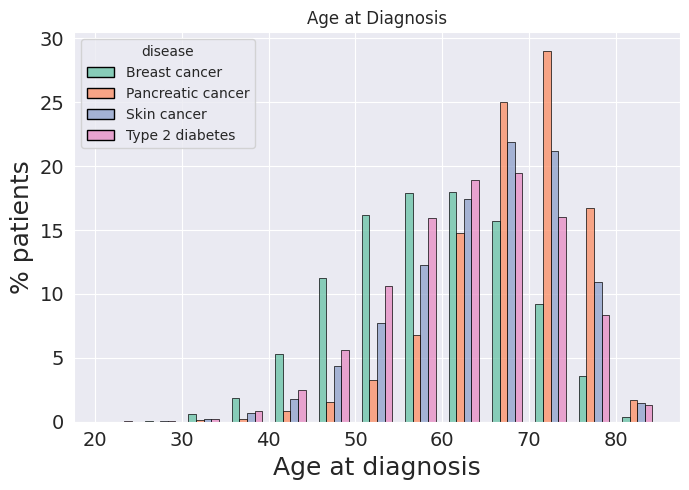

In [25]:
age_at_diagnosis_hist(filtered_df, target_codes=["C50", "C25", "C44", "E11"], target_names=["Breast cancer", "Pancreatic cancer", "Skin cancer", "Type 2 diabetes"], bins=range(20, 90, 5))

In [33]:
from matplotlib.colors import LinearSegmentedColormap

def extract_summary(raw_df, disease_cols):
    df = raw_df.copy()

    df[diagnosis_cols] = df[diagnosis_cols].apply(pd.to_datetime, errors="coerce")

    n_diagnoses = df[disease_cols].notna().sum(axis=1)
    min_dates = df[disease_cols].min(axis=1)
    max_dates = df[disease_cols].max(axis=1)
    trajectory_length = (max_dates - min_dates).dt.days / 365.25
    return pd.DataFrame({
        "n_diagnoses": n_diagnoses,
        "trajectory_length": trajectory_length
    }).dropna()

def plot_trajectory_heatmap(data1, data2, label1, label2, main_title, bins_x=30, bins_y=30):
    """
    Plot side-by-side 2D histograms (heatmaps) of trajectory length vs.
    number of diagnoses for two cohorts.

    Parameters
    ----------
    data1, data2 : pandas.DataFrame
        Cohort data containing columns:
        - 'trajectory_length' (years)
        - 'n_diagnoses' (count of diagnosis codes).
    label1, label2 : str
        Titles for the two subplots (e.g., cohort names).
    main_title : str
        Overall figure title.
    bins_x, bins_y : int, optional
        Number of bins for trajectory length (x-axis) and
        number of diagnoses (y-axis). Default is 30 each.
    """

    fig, axes = plt.subplots(1, 2, figsize=(10, 10), sharex=True, sharey=True, gridspec_kw={"bottom": 0.18, "top": 0.9, "wspace": 0.15}, facecolor="white")

    for ax in axes:
        ax.set_facecolor("white")
        ax.grid(True, color="black", linewidth=0.3, alpha=0.3)
        ax.tick_params(axis="both", which="major", labelsize=12)

        for spine in ax.spines.values():
            spine.set_edgecolor("black")
            spine.set_linewidth(1.2)


    cmap_cancer = LinearSegmentedColormap.from_list(
        "cancer", ["#fde0c5", "#f08c82", "#7a0177", "black"]
    )
    cmap_nocancer = LinearSegmentedColormap.from_list(
        "nocancer", ["#e0f3db", "#43a2ca", "#0868ac", "black"]
    )

    h1 = axes[0].hist2d(
        data1["trajectory_length"],
        data1["n_diagnoses"],
        bins=[bins_x, bins_y],
        cmap=cmap_cancer,
        cmin=1
    )

    axes[0].set_title(label1, fontsize=18)

    h2 = axes[1].hist2d(
        data2["trajectory_length"],
        data2["n_diagnoses"],
        bins=[bins_x, bins_y],
        cmap=cmap_nocancer,
        cmin=1
    )
    axes[1].set_title(label2, fontsize=18)

    fig.suptitle(main_title, fontsize=20, y=0.96)
    fig.text(0.5, 0.14, "Trajectory length (years)", ha="center", va="center", fontsize=16)
    fig.text(0.08, 0.5, "Number of disease codes", va="center", ha="right", rotation=90, fontsize=14)

    cbar_ax1 = fig.add_axes([0.15, 0.1, 0.7, 0.02])  # [left, bottom, width, height]
    cbar_ax2 = fig.add_axes([0.15, 0.05, 0.7, 0.02])
    fig.colorbar(h1[3], cax=cbar_ax1, orientation="horizontal")
    fig.colorbar(h2[3], cax=cbar_ax2, orientation="horizontal")

    fig.text(0.08, 0.08, "N patients", va="center", ha="right", rotation=90, fontsize=14)

    plt.show()


In [27]:
# Summary df for breast cancer all
breast_cancer_df = filtered_df[filtered_df["C50"].notna()]
no_breast_cancer_df = filtered_df[filtered_df["C50"].isna()]

breast_cancer_data = extract_summary(breast_cancer_df, diagnosis_cols)
no_breast_cancer_data = extract_summary(no_breast_cancer_df, diagnosis_cols)

# Summary df for breast cancer females
breast_cancer_fem_df = filtered_df[(filtered_df["C50"].notna()) & (filtered_df["Sex"] == "Female")]
no_breast_cancer_fem_df = filtered_df[(filtered_df["C50"].isna()) & (filtered_df["Sex"] == "Female")]

breast_cancer_fem_data = extract_summary(breast_cancer_fem_df, diagnosis_cols)
no_breast_cancer_fem_data = extract_summary(no_breast_cancer_fem_df, diagnosis_cols)

# Summary df for pancreatic cancer
pancreatic_cancer_df = filtered_df[filtered_df["C25"].notna()]
no_pancreatic_cancer_df = filtered_df[filtered_df["C25"].isna()]

pancreatic_cancer_data = extract_summary(pancreatic_cancer_df, diagnosis_cols)
no_pancreatic_cancer_data = extract_summary(no_pancreatic_cancer_df, diagnosis_cols)

# Summary df for skin cancer
skin_cancer_df = filtered_df[filtered_df["C44"].notna()]
no_skin_cancer_df = filtered_df[filtered_df["C44"].isna()]

skin_cancer_data = extract_summary(skin_cancer_df, diagnosis_cols)
no_skin_cancer_data = extract_summary(no_skin_cancer_df, diagnosis_cols)

# Summary df for diabetes
diabetes_df = filtered_df[filtered_df["E11"].notna()]
no_diabetes_df = filtered_df[filtered_df["E11"].isna()]

diabetes_data = extract_summary(diabetes_df, diagnosis_cols)
no_diabetes_data = extract_summary(no_diabetes_df, diagnosis_cols)

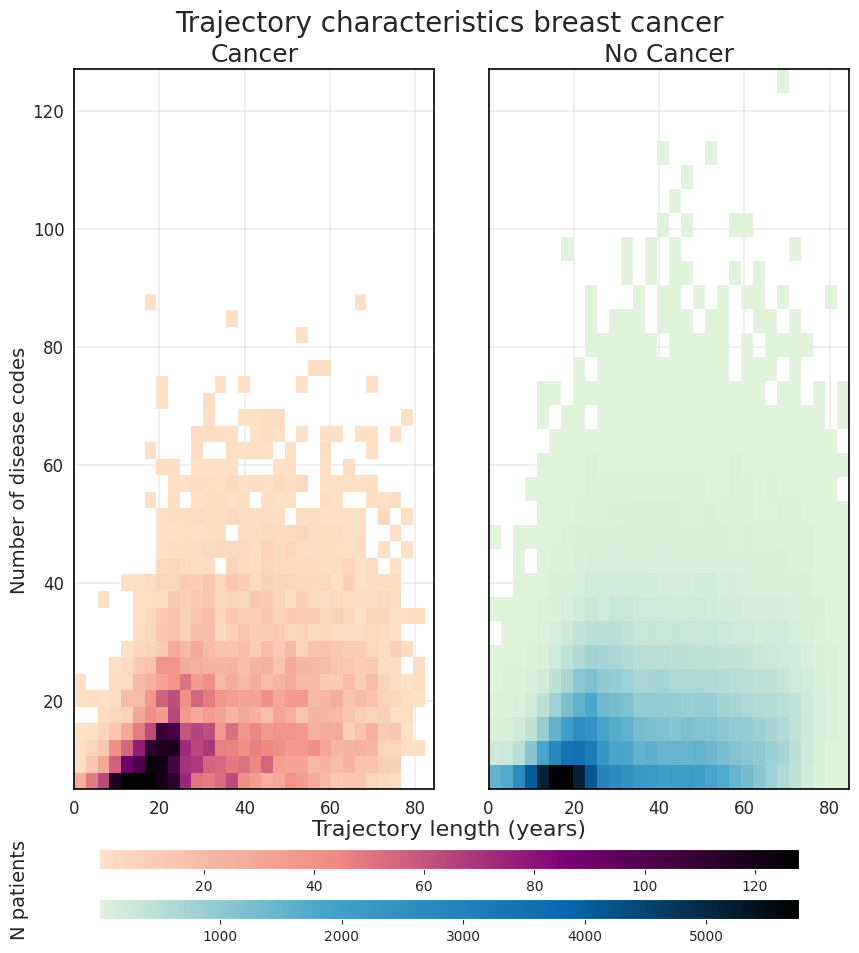

In [34]:
plot_trajectory_heatmap(breast_cancer_data, no_breast_cancer_data, "Cancer", "No Cancer", "Trajectory characteristics breast cancer")

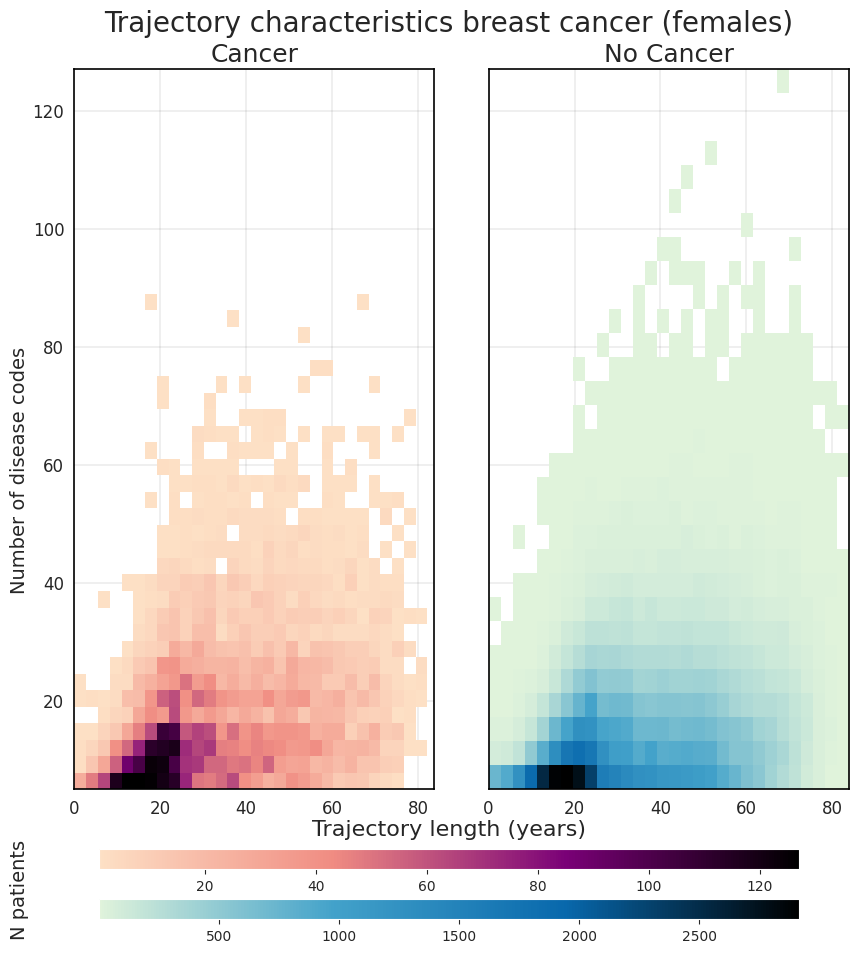

In [35]:
plot_trajectory_heatmap(breast_cancer_fem_data, no_breast_cancer_fem_data, "Cancer", "No Cancer", "Trajectory characteristics breast cancer (females)")

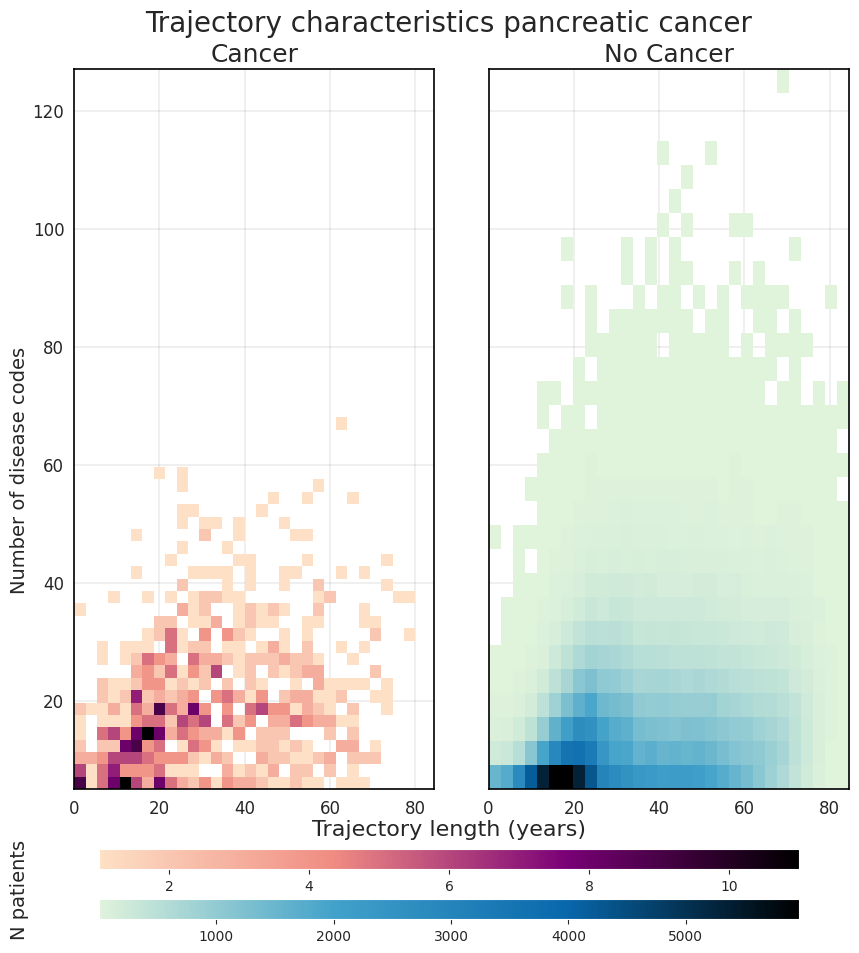

In [36]:
plot_trajectory_heatmap(pancreatic_cancer_data, no_pancreatic_cancer_data, "Cancer", "No Cancer", "Trajectory characteristics pancreatic cancer")

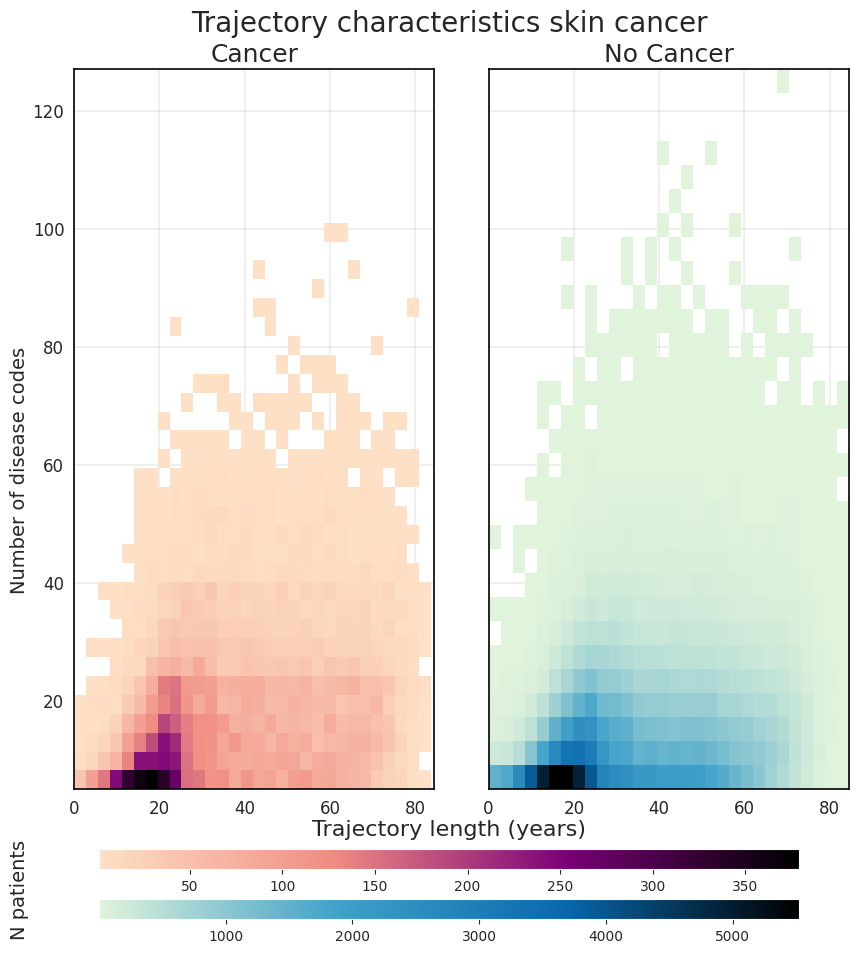

In [37]:
plot_trajectory_heatmap(skin_cancer_data, no_skin_cancer_data, "Cancer", "No Cancer", "Trajectory characteristics skin cancer")

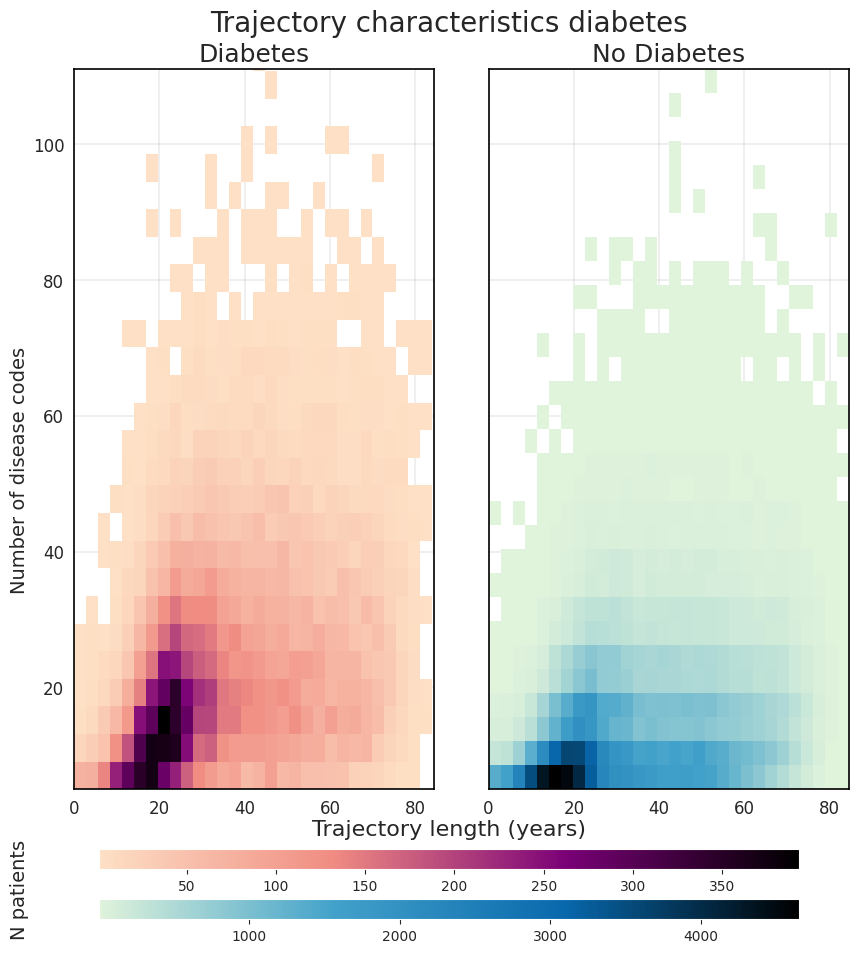

In [38]:
plot_trajectory_heatmap(diabetes_data, no_diabetes_data, "Diabetes", "No Diabetes", "Trajectory characteristics diabetes")